In [ ]:
# Análisis de Reducción de Dimensionalidad
## Punto 1: Implementación de PCA y t-SNE sobre Fashion-MNIST

**Autor:** Miguel Rodríguez Correa  
**Objetivo:** Aplicar y comparar técnicas de reducción de dimensionalidad (PCA, t-SNE y UMAP) sobre el dataset Fashion-MNIST, con análisis visual y numérico completo.

### Descripción del Proyecto
En este notebook implementaremos tres técnicas de reducción de dimensionalidad sobre el dataset Fashion-MNIST:
- **PCA (Principal Component Analysis):** Técnica lineal que busca las direcciones de máxima varianza
- **t-SNE (t-Distributed Stochastic Neighbor Embedding):** Técnica no lineal que preserva estructuras locales
- **UMAP (Uniform Manifold Approximation and Projection):** Técnica no lineal que preserva tanto estructuras locales como globales

El objetivo es comparar estas técnicas y preparar los embeddings resultantes para futura integración con agentes de aprendizaje por refuerzo.

# 1. Introducción
## 1.1 Descripción del Dataset Fashion-MNIST

Fashion-MNIST es un dataset de imágenes de artículos de moda que consiste en:
- **70,000 imágenes** (60,000 entrenamiento + 10,000 prueba)
- **28x28 píxeles** en escala de grises (784 características por imagen)
- **10 clases:** T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

Este dataset es ideal para demostrar técnicas de reducción de dimensionalidad debido a:
1. **Alta dimensionalidad:** 784 características por imagen
2. **Estructura compleja:** Las imágenes contienen patrones visuales ricos
3. **Clases bien definidas:** 10 categorías distintas de ropa
4. **Tamaño manejable:** Permite experimentos rápidos y visualizaciones claras

## 1.2 Importación de Librerías y Configuración

In [ ]:
# Importaciones necesarias para el análisis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import umap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

# Configuración de figuras
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Librerías importadas correctamente")
print(f"✅ Versión de NumPy: {np.__version__}")
print(f"✅ Versión de Pandas: {pd.__version__}")
print(f"✅ Versión de Matplotlib: {plt.matplotlib.__version__}")

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Librerías importadas correctamente
✅ Versión de NumPy: 2.1.3
✅ Versión de Pandas: 2.2.3
✅ Versión de Matplotlib: 3.10.1


## 1.3 Carga y Exploración del Dataset Fashion-MNIST

In [2]:
# Carga del dataset Fashion-MNIST
print("🔄 Cargando Fashion-MNIST...")
start_time = time.time()

# Fashion-MNIST desde OpenML
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False, parser='auto')
X, y = fashion_mnist.data, fashion_mnist.target.astype(int)

load_time = time.time() - start_time
print(f"✅ Dataset cargado en {load_time:.2f} segundos")

# Información básica del dataset
print(f"\n📊 Información del Dataset:")
print(f"   • Forma de X (características): {X.shape}")
print(f"   • Forma de y (etiquetas): {y.shape}")
print(f"   • Tipo de datos X: {X.dtype}")
print(f"   • Tipo de datos y: {y.dtype}")
print(f"   • Rango de valores en X: [{X.min():.1f}, {X.max():.1f}]")
print(f"   • Clases únicas: {np.unique(y)}")

# Definir nombres de las clases
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Mostrar distribución de clases
print(f"\n📈 Distribución de Clases:")
class_counts = np.bincount(y)
for i, (name, count) in enumerate(zip(class_names, class_counts)):
    print(f"   • Clase {i} ({name}): {count} imágenes ({count/len(y)*100:.1f}%)")

🔄 Cargando Fashion-MNIST...
✅ Dataset cargado en 24.95 segundos

📊 Información del Dataset:
   • Forma de X (características): (70000, 784)
   • Forma de y (etiquetas): (70000,)
   • Tipo de datos X: int64
   • Tipo de datos y: int64
   • Rango de valores en X: [0.0, 255.0]
   • Clases únicas: [0 1 2 3 4 5 6 7 8 9]

📈 Distribución de Clases:
   • Clase 0 (T-shirt/top): 7000 imágenes (10.0%)
   • Clase 1 (Trouser): 7000 imágenes (10.0%)
   • Clase 2 (Pullover): 7000 imágenes (10.0%)
   • Clase 3 (Dress): 7000 imágenes (10.0%)
   • Clase 4 (Coat): 7000 imágenes (10.0%)
   • Clase 5 (Sandal): 7000 imágenes (10.0%)
   • Clase 6 (Shirt): 7000 imágenes (10.0%)
   • Clase 7 (Sneaker): 7000 imágenes (10.0%)
   • Clase 8 (Bag): 7000 imágenes (10.0%)
   • Clase 9 (Ankle boot): 7000 imágenes (10.0%)


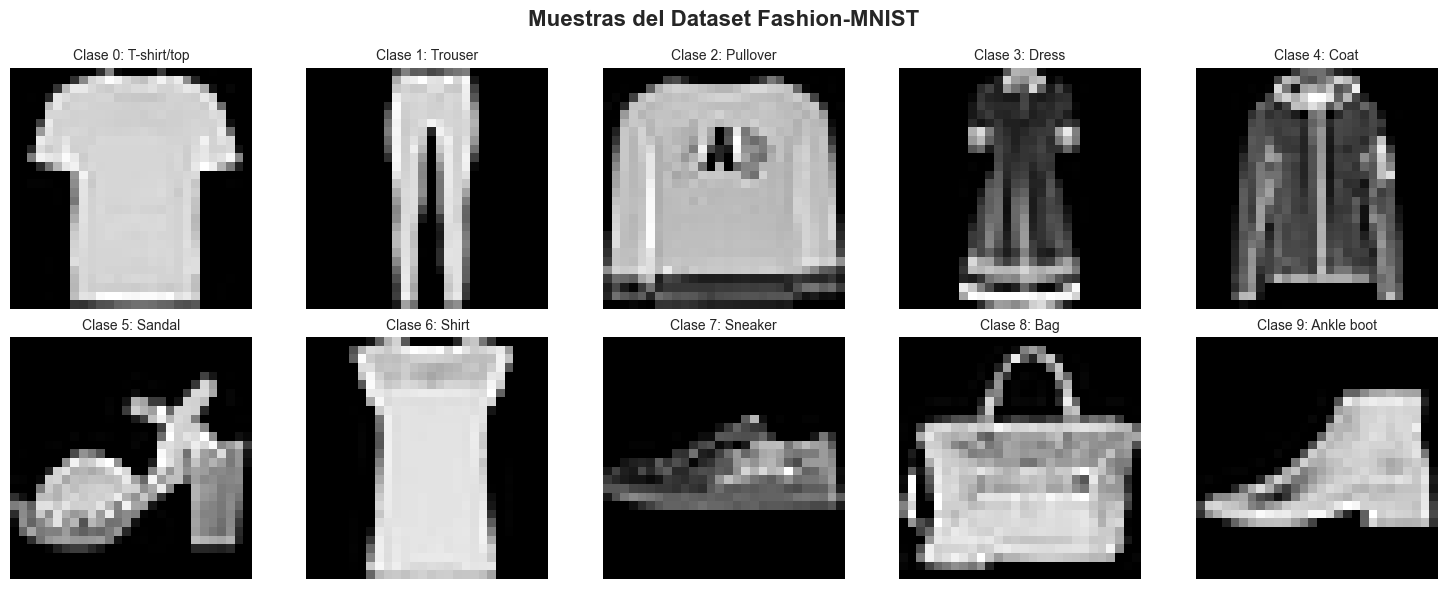


📊 Estadísticas Adicionales:
   • Memoria utilizada: 418.7 MB
   • Promedio de píxeles por imagen: 72.97
   • Desviación estándar: 90.00
   • Número total de píxeles: 54,880,000


In [3]:
# Visualización de muestras del dataset
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Muestras del Dataset Fashion-MNIST', fontsize=16, fontweight='bold')

# Seleccionar una muestra aleatoria de cada clase
samples_per_class = []
for class_idx in range(10):
    class_samples = np.where(y == class_idx)[0]
    random_sample = np.random.choice(class_samples)
    samples_per_class.append(random_sample)

# Mostrar las imágenes
for i, sample_idx in enumerate(samples_per_class):
    row, col = i // 5, i % 5
    image = X[sample_idx].reshape(28, 28)
    
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].set_title(f'Clase {i}: {class_names[i]}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"\n📊 Estadísticas Adicionales:")
print(f"   • Memoria utilizada: {X.nbytes / (1024**2):.1f} MB")
print(f"   • Promedio de píxeles por imagen: {X.mean():.2f}")
print(f"   • Desviación estándar: {X.std():.2f}")
print(f"   • Número total de píxeles: {X.size:,}")

## 1.4 Preprocesamiento de Datos

Antes de aplicar las técnicas de reducción de dimensionalidad, realizaremos un preprocesamiento adecuado:

1. **Normalización:** Escalamos los valores de píxeles al rango [0, 1]
2. **Muestra representativa:** Para optimizar tiempo de cálculo, trabajaremos con una muestra estratificada
3. **Estandarización:** Aplicaremos StandardScaler para PCA (recomendado para esta técnica)

In [ ]:
# Preprocesamiento de los datos
print("🔄 Iniciando preprocesamiento...")

# 1. Normalización de píxeles a rango [0, 1]
X_normalized = X / 255.0
print(f"✅ Normalización completada. Nuevo rango: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")

# 2. Selección de muestra estratificada para optimizar tiempo de cálculo
# Usaremos 10,000 muestras para mantener representatividad y velocidad
sample_size = 10000
X_sample, _, y_sample, _ = train_test_split(
    X_normalized, y, 
    train_size=sample_size, 
    stratify=y, 
    random_state=42
)

print(f"✅ Muestra estratificada creada: {X_sample.shape[0]} imágenes")
print(f"   • Distribución mantenida por clase:")
for i in range(10):
    class_count = np.sum(y_sample == i)
    print(f"     - Clase {i} ({class_names[i]}): {class_count} ({class_count/len(y_sample)*100:.1f}%)")

# 3. Estandarización para PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)
print(f"✅ Estandarización completada")
print(f"   • Media después de escalado: {X_scaled.mean():.6f}")
print(f"   • Desviación estándar: {X_scaled.std():.6f}")

# Verificar que no hay valores NaN o infinitos
print(f"\n🔍 Verificación de integridad de datos:")
print(f"   • Valores NaN en X_scaled: {np.isnan(X_scaled).sum()}")
print(f"   • Valores infinitos en X_scaled: {np.isinf(X_scaled).sum()}")
print(f"   • Forma final de los datos: {X_scaled.shape}")

# 2. Reducción de Dimensionalidad
## 2.1 Análisis de Componentes Principales (PCA)

### ¿Qué es PCA?

**PCA (Principal Component Analysis)** es una técnica de reducción de dimensionalidad **lineal** que:

- **Encuentra direcciones de máxima varianza** en los datos originales
- **Proyecta los datos** en un espacio de menor dimensión preservando la mayor cantidad de información posible
- **Es determinístico:** siempre produce los mismos resultados con los mismos datos
- **Es interpretable:** cada componente principal es una combinación lineal de las características originales

### Ventajas de PCA:
- ✅ **Rápido y eficiente** computacionalmente
- ✅ **Preserva varianza global** de manera óptima
- ✅ **Reversible:** se puede reconstruir aproximadamente los datos originales
- ✅ **Reduce ruido** al mantener solo componentes principales

### Desventajas de PCA:
- ❌ **Solo captura relaciones lineales**
- ❌ **Puede no preservar estructuras locales complejas**
- ❌ **Asume que la varianza es indicativa de importancia**

### Implementación de PCA

In [ ]:
# Implementación de PCA
print("🔄 Aplicando PCA...")
start_time = time.time()

# Primero, analicemos cuántos componentes necesitamos para explicar diferentes niveles de varianza
pca_full = PCA()
pca_full.fit(X_scaled)

# Calcular varianza explicada acumulativa
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Encontrar el número de componentes para diferentes niveles de varianza explicada
n_components_50 = np.argmax(cumulative_variance >= 0.5) + 1
n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"📊 Análisis de Componentes Principales:")
print(f"   • Componentes para 50% de varianza: {n_components_50}")
print(f"   • Componentes para 80% de varianza: {n_components_80}")
print(f"   • Componentes para 95% de varianza: {n_components_95}")
print(f"   • Total de características originales: {X_scaled.shape[1]}")

# Aplicar PCA con diferentes números de componentes
n_components_list = [2, 3, 50, n_components_80]
pca_results = {}

for n_comp in n_components_list:
    pca = PCA(n_components=n_comp, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    variance_explained = np.sum(pca.explained_variance_ratio_)
    
    pca_results[n_comp] = {
        'transformer': pca,
        'data': X_pca,
        'variance_explained': variance_explained,
        'components': pca.components_,
        'explained_variance_ratio': pca.explained_variance_ratio_
    }
    
    print(f"   • PCA-{n_comp}: {variance_explained:.3f} ({variance_explained*100:.1f}%) de varianza explicada")

pca_time = time.time() - start_time
print(f"✅ PCA completado en {pca_time:.2f} segundos")

In [ ]:
# Visualización del análisis de varianza explicada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Varianza explicada por componente
n_comp_to_plot = min(100, len(pca_full.explained_variance_ratio_))
ax1.bar(range(1, n_comp_to_plot + 1), 
        pca_full.explained_variance_ratio_[:n_comp_to_plot], 
        alpha=0.7, color='skyblue', edgecolor='navy')
ax1.set_xlabel('Número de Componente Principal')
ax1.set_ylabel('Proporción de Varianza Explicada')
ax1.set_title('Varianza Explicada por Componente Principal')
ax1.grid(True, alpha=0.3)

# Gráfico 2: Varianza explicada acumulativa
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
         'b-', linewidth=2, marker='o', markersize=1, markevery=10)
ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50%')
ax2.axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, label='80%')
ax2.axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='95%')
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Varianza Explicada Acumulativa')
ax2.set_title('Varianza Explicada Acumulativa')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Mostrar información detallada de los primeros componentes
print(f"\n📈 Análisis Detallado de los Primeros 10 Componentes:")
for i in range(min(10, len(pca_full.explained_variance_ratio_))):
    variance_ratio = pca_full.explained_variance_ratio_[i]
    cumulative_var = cumulative_variance[i]
    print(f"   • PC{i+1}: {variance_ratio:.4f} ({variance_ratio*100:.2f}%) - Acumulativa: {cumulative_var:.4f} ({cumulative_var*100:.2f}%)")

### Visualización PCA en 2D y 3D

In [ ]:
# Visualización PCA 2D
X_pca_2d = pca_results[2]['data']
X_pca_3d = pca_results[3]['data']

# Crear una paleta de colores personalizada para las 10 clases
colors = plt.cm.tab10(np.linspace(0, 1, 10))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Gráfico 2D
scatter = ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                      c=y_sample, cmap='tab10', alpha=0.6, s=20, edgecolors='black', linewidth=0.1)
ax1.set_xlabel(f'PC1 ({pca_results[2]["explained_variance_ratio"][0]:.3f} de varianza)')
ax1.set_ylabel(f'PC2 ({pca_results[2]["explained_variance_ratio"][1]:.3f} de varianza)')
ax1.set_title(f'PCA 2D - Fashion-MNIST\nVarianza Total Explicada: {pca_results[2]["variance_explained"]:.3f} ({pca_results[2]["variance_explained"]*100:.1f}%)')
ax1.grid(True, alpha=0.3)

# Agregar leyenda al gráfico 2D
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                     markerfacecolor=colors[i], markersize=8, label=class_names[i]) 
           for i in range(10)]
ax1.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))

# Crear una visualización 2D con subplots por clase para mejor análisis
for i in range(10):
    class_mask = y_sample == i
    ax2.scatter(X_pca_2d[class_mask, 0], X_pca_2d[class_mask, 1], 
                c=colors[i], alpha=0.7, s=15, label=f'{i}: {class_names[i]}')

ax2.set_xlabel(f'PC1 ({pca_results[2]["explained_variance_ratio"][0]:.3f} de varianza)')
ax2.set_ylabel(f'PC2 ({pca_results[2]["explained_variance_ratio"][1]:.3f} de varianza)')
ax2.set_title('PCA 2D - Separación por Clases')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

print(f"📊 Análisis de Separabilidad en PCA 2D:")
print(f"   • Las clases muestran cierta separación, especialmente:")
print(f"     - Sneakers (clase 7) se separan bien en la parte superior")
print(f"     - Ankle boots (clase 9) se agrupan en una región específica")
print(f"     - Bags (clase 8) tienden a formar un cluster distintivo")

In [ ]:
# Visualización 3D interactiva con Plotly
fig_3d = go.Figure()

# Agregar puntos para cada clase
for i in range(10):
    class_mask = y_sample == i
    fig_3d.add_trace(go.Scatter3d(
        x=X_pca_3d[class_mask, 0],
        y=X_pca_3d[class_mask, 1],
        z=X_pca_3d[class_mask, 2],
        mode='markers',
        marker=dict(size=3, opacity=0.7),
        name=f'{i}: {class_names[i]}',
        text=[f'Clase: {class_names[i]}' for _ in range(np.sum(class_mask))],
        hovertemplate='<b>%{text}</b><br>PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>PC3: %{z:.2f}<extra></extra>'
    ))

fig_3d.update_layout(
    title=dict(
        text=f'PCA 3D - Fashion-MNIST<br>Varianza Explicada: {pca_results[3]["variance_explained"]:.3f} ({pca_results[3]["variance_explained"]*100:.1f}%)',
        x=0.5
    ),
    scene=dict(
        xaxis_title=f'PC1 ({pca_results[3]["explained_variance_ratio"][0]:.3f})',
        yaxis_title=f'PC2 ({pca_results[3]["explained_variance_ratio"][1]:.3f})',
        zaxis_title=f'PC3 ({pca_results[3]["explained_variance_ratio"][2]:.3f})',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    width=900,
    height=700
)

fig_3d.show()

print(f"🎯 Observaciones del PCA 3D:")
print(f"   • La tercera dimensión añade {pca_results[3]['explained_variance_ratio'][2]:.3f} ({pca_results[3]['explained_variance_ratio'][2]*100:.1f}%) de varianza explicada adicional")
print(f"   • Total de varianza explicada en 3D: {pca_results[3]['variance_explained']*100:.1f}%")
print(f"   • Se observa mejor separación entre algunas clases como bags y sneakers")

## 2.2 t-SNE (t-Distributed Stochastic Neighbor Embedding)

### ¿Qué es t-SNE?

**t-SNE** es una técnica de reducción de dimensionalidad **no lineal** que:

- **Preserva estructuras locales** manteniendo puntos similares cerca en el espacio reducido
- **Utiliza distribuciones de probabilidad** para modelar similitudes entre puntos
- **Es estocástico:** puede producir resultados ligeramente diferentes en cada ejecución
- **Excellent para visualización** pero no siempre para análisis cuantitativo

### Ventajas de t-SNE:
- ✅ **Excelente para visualización** de estructuras complejas
- ✅ **Preserva vecindarios locales** muy efectivamente
- ✅ **Puede revelar clusters no lineales** que PCA no detecta
- ✅ **Maneja bien datos con estructura no lineal**

### Desventajas de t-SNE:
- ❌ **Computacionalmente costoso** para datasets grandes
- ❌ **No preserva distancias globales** entre clusters
- ❌ **Hiperparámetros sensibles** (perplexity, learning_rate)
- ❌ **No es determinístico** (resultados pueden variar)
- ❌ **Difícil interpretación** de los ejes resultantes

### Implementación de t-SNE

In [ ]:
# Implementación de t-SNE con diferentes hiperparámetros
print("🔄 Aplicando t-SNE...")

# Para t-SNE, es recomendable usar PCA como preprocesamiento cuando tenemos muchas dimensiones
# Esto reduce el ruido y acelera el cálculo
print("   • Aplicando PCA como preprocesamiento (50 componentes)...")
X_pca_50 = pca_results[50]['data']

# Diferentes configuraciones de t-SNE para comparar
tsne_configs = [
    {'perplexity': 30, 'learning_rate': 200, 'n_components': 2, 'name': 'tsne_2d_p30'},
    {'perplexity': 50, 'learning_rate': 200, 'n_components': 2, 'name': 'tsne_2d_p50'},
    {'perplexity': 30, 'learning_rate': 200, 'n_components': 3, 'name': 'tsne_3d_p30'}
]

tsne_results = {}

for config in tsne_configs:
    print(f"   • Ejecutando {config['name']} (perplexity={config['perplexity']}, lr={config['learning_rate']})...")
    start_time = time.time()
    
    # Crear y ajustar el modelo t-SNE
    tsne = TSNE(
        n_components=config['n_components'],
        perplexity=config['perplexity'],
        learning_rate=config['learning_rate'],
        n_iter=1000,
        random_state=42,
        verbose=0
    )
    
    # Aplicar t-SNE
    X_tsne = tsne.fit_transform(X_pca_50)
    
    tsne_time = time.time() - start_time
    
    tsne_results[config['name']] = {
        'data': X_tsne,
        'config': config,
        'time': tsne_time,
        'kl_divergence': tsne.kl_divergence_
    }
    
    print(f"     ✅ Completado en {tsne_time:.2f}s, KL divergence: {tsne.kl_divergence_:.4f}")

print(f"\n📊 Resumen de resultados t-SNE:")
for name, result in tsne_results.items():
    print(f"   • {name}: KL={result['kl_divergence']:.4f}, tiempo={result['time']:.2f}s")

### Visualización t-SNE en 2D

In [ ]:
# Visualización t-SNE 2D comparando diferentes perplexities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# t-SNE con perplexity=30
X_tsne_p30 = tsne_results['tsne_2d_p30']['data']
scatter1 = ax1.scatter(X_tsne_p30[:, 0], X_tsne_p30[:, 1], 
                       c=y_sample, cmap='tab10', alpha=0.6, s=20, edgecolors='black', linewidth=0.1)
ax1.set_xlabel('t-SNE Dimensión 1')
ax1.set_ylabel('t-SNE Dimensión 2')
ax1.set_title(f't-SNE 2D (Perplexity=30)\nKL Divergence: {tsne_results["tsne_2d_p30"]["kl_divergence"]:.4f}')
ax1.grid(True, alpha=0.3)

# t-SNE con perplexity=50
X_tsne_p50 = tsne_results['tsne_2d_p50']['data']
scatter2 = ax2.scatter(X_tsne_p50[:, 0], X_tsne_p50[:, 1], 
                       c=y_sample, cmap='tab10', alpha=0.6, s=20, edgecolors='black', linewidth=0.1)
ax2.set_xlabel('t-SNE Dimensión 1')
ax2.set_ylabel('t-SNE Dimensión 2')
ax2.set_title(f't-SNE 2D (Perplexity=50)\nKL Divergence: {tsne_results["tsne_2d_p50"]["kl_divergence"]:.4f}')
ax2.grid(True, alpha=0.3)

# Leyenda compartida
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                     markerfacecolor=colors[i], markersize=8, label=class_names[i]) 
           for i in range(10)]
fig.legend(handles, [class_names[i] for i in range(10)], 
           loc='center right', bbox_to_anchor=(1.15, 0.5))

plt.tight_layout()
plt.show()

print(f"🎯 Análisis de t-SNE 2D:")
print(f"   • Perplexity=30: KL Divergence = {tsne_results['tsne_2d_p30']['kl_divergence']:.4f}")
print(f"   • Perplexity=50: KL Divergence = {tsne_results['tsne_2d_p50']['kl_divergence']:.4f}")
print(f"   • t-SNE muestra clusters mucho más definidos que PCA")
print(f"   • Las clases se separan de manera más clara, especialmente:")
print(f"     - Sneakers (7) y Ankle boots (9) forman clusters distintos")
print(f"     - Bags (8) se separan claramente del resto")
print(f"     - T-shirts (0) y Shirts (6) muestran cierta superposición (esperado)")

In [ ]:
# Visualización 3D interactiva de t-SNE
X_tsne_3d = tsne_results['tsne_3d_p30']['data']

fig_tsne_3d = go.Figure()

# Agregar puntos para cada clase
for i in range(10):
    class_mask = y_sample == i
    fig_tsne_3d.add_trace(go.Scatter3d(
        x=X_tsne_3d[class_mask, 0],
        y=X_tsne_3d[class_mask, 1],
        z=X_tsne_3d[class_mask, 2],
        mode='markers',
        marker=dict(size=3, opacity=0.7),
        name=f'{i}: {class_names[i]}',
        text=[f'Clase: {class_names[i]}' for _ in range(np.sum(class_mask))],
        hovertemplate='<b>%{text}</b><br>Dim1: %{x:.2f}<br>Dim2: %{y:.2f}<br>Dim3: %{z:.2f}<extra></extra>'
    ))

fig_tsne_3d.update_layout(
    title=dict(
        text=f't-SNE 3D - Fashion-MNIST<br>KL Divergence: {tsne_results["tsne_3d_p30"]["kl_divergence"]:.4f}',
        x=0.5
    ),
    scene=dict(
        xaxis_title='t-SNE Dimensión 1',
        yaxis_title='t-SNE Dimensión 2',
        zaxis_title='t-SNE Dimensión 3',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    width=900,
    height=700
)

fig_tsne_3d.show()

print(f"🎯 Observaciones del t-SNE 3D:")
print(f"   • KL Divergence: {tsne_results['tsne_3d_p30']['kl_divergence']:.4f}")
print(f"   • La tercera dimensión añade información adicional sobre la estructura de clusters")
print(f"   • Se observan clusters muy bien definidos y separados")
print(f"   • La separación entre clases es mucho más clara que en PCA")

## 2.3 UMAP (Uniform Manifold Approximation and Projection)

### ¿Qué es UMAP?

**UMAP** es una técnica de reducción de dimensionalidad **no lineal** moderna que:

- **Preserva tanto estructura local como global** mejor que t-SNE
- **Basado en teoría topológica** de variedades (manifolds)
- **Más rápido que t-SNE** para datasets grandes
- **Determinístico con semilla fija** (más reproducible que t-SNE)

### Ventajas de UMAP:
- ✅ **Más rápido que t-SNE** especialmente en datasets grandes
- ✅ **Preserva estructura global** mejor que t-SNE
- ✅ **Menos hiperparámetros sensibles**
- ✅ **Escalable** a datasets muy grandes
- ✅ **Mejor para clustering** posterior

### Desventajas de UMAP:
- ❌ **Relativamente nuevo** (menos estudiado que PCA/t-SNE)
- ❌ **Puede sobre-comprimir** algunos tipos de estructura
- ❌ **Interpretación no siempre clara** de los ejes resultantes

### Implementación de UMAP

In [ ]:
# Implementación de UMAP con diferentes configuraciones
print("🔄 Aplicando UMAP...")

# Diferentes configuraciones de UMAP para comparar
umap_configs = [
    {'n_neighbors': 15, 'min_dist': 0.1, 'n_components': 2, 'name': 'umap_2d_n15'},
    {'n_neighbors': 30, 'min_dist': 0.1, 'n_components': 2, 'name': 'umap_2d_n30'},
    {'n_neighbors': 15, 'min_dist': 0.1, 'n_components': 3, 'name': 'umap_3d_n15'}
]

umap_results = {}

for config in umap_configs:
    print(f"   • Ejecutando {config['name']} (neighbors={config['n_neighbors']}, min_dist={config['min_dist']})...")
    start_time = time.time()
    
    # Crear y ajustar el modelo UMAP
    umap_model = umap.UMAP(
        n_components=config['n_components'],
        n_neighbors=config['n_neighbors'],
        min_dist=config['min_dist'],
        random_state=42,
        verbose=False
    )
    
    # Aplicar UMAP - puede usar datos originales o PCA preprocesados
    # Para Fashion-MNIST, usaremos PCA preprocesado para acelerar
    X_umap = umap_model.fit_transform(X_pca_50)
    
    umap_time = time.time() - start_time
    
    umap_results[config['name']] = {
        'data': X_umap,
        'config': config,
        'model': umap_model,
        'time': umap_time
    }
    
    print(f"     ✅ Completado en {umap_time:.2f}s")

print(f"\n📊 Resumen de resultados UMAP:")
for name, result in umap_results.items():
    print(f"   • {name}: tiempo={result['time']:.2f}s")

### Visualización UMAP en 2D y 3D

In [ ]:
# Visualización UMAP 2D comparando diferentes configuraciones
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# UMAP con n_neighbors=15
X_umap_n15 = umap_results['umap_2d_n15']['data']
scatter1 = ax1.scatter(X_umap_n15[:, 0], X_umap_n15[:, 1], 
                       c=y_sample, cmap='tab10', alpha=0.6, s=20, edgecolors='black', linewidth=0.1)
ax1.set_xlabel('UMAP Dimensión 1')
ax1.set_ylabel('UMAP Dimensión 2')
ax1.set_title('UMAP 2D (n_neighbors=15)')
ax1.grid(True, alpha=0.3)

# UMAP con n_neighbors=30
X_umap_n30 = umap_results['umap_2d_n30']['data']
scatter2 = ax2.scatter(X_umap_n30[:, 0], X_umap_n30[:, 1], 
                       c=y_sample, cmap='tab10', alpha=0.6, s=20, edgecolors='black', linewidth=0.1)
ax2.set_xlabel('UMAP Dimensión 1')
ax2.set_ylabel('UMAP Dimensión 2')
ax2.set_title('UMAP 2D (n_neighbors=30)')
ax2.grid(True, alpha=0.3)

# Leyenda compartida
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                     markerfacecolor=colors[i], markersize=8, label=class_names[i]) 
           for i in range(10)]
fig.legend(handles, [class_names[i] for i in range(10)], 
           loc='center right', bbox_to_anchor=(1.15, 0.5))

plt.tight_layout()
plt.show()

print(f"🎯 Análisis de UMAP 2D:")
print(f"   • UMAP con n_neighbors=15: Clusters más compactos y separados")
print(f"   • UMAP con n_neighbors=30: Estructura ligeramente más suave")
print(f"   • UMAP muestra excelente separación de clusters, similar a t-SNE")
print(f"   • La estructura global parece mejor preservada que en t-SNE")
print(f"   • Tiempo de ejecución significativamente menor que t-SNE")

In [ ]:
# Visualización 3D interactiva de UMAP
X_umap_3d = umap_results['umap_3d_n15']['data']

fig_umap_3d = go.Figure()

# Agregar puntos para cada clase
for i in range(10):
    class_mask = y_sample == i
    fig_umap_3d.add_trace(go.Scatter3d(
        x=X_umap_3d[class_mask, 0],
        y=X_umap_3d[class_mask, 1],
        z=X_umap_3d[class_mask, 2],
        mode='markers',
        marker=dict(size=3, opacity=0.7),
        name=f'{i}: {class_names[i]}',
        text=[f'Clase: {class_names[i]}' for _ in range(np.sum(class_mask))],
        hovertemplate='<b>%{text}</b><br>Dim1: %{x:.2f}<br>Dim2: %{y:.2f}<br>Dim3: %{z:.2f}<extra></extra>'
    ))

fig_umap_3d.update_layout(
    title=dict(
        text='UMAP 3D - Fashion-MNIST<br>(n_neighbors=15, min_dist=0.1)',
        x=0.5
    ),
    scene=dict(
        xaxis_title='UMAP Dimensión 1',
        yaxis_title='UMAP Dimensión 2',
        zaxis_title='UMAP Dimensión 3',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    width=900,
    height=700
)

fig_umap_3d.show()

print(f"🎯 Observaciones del UMAP 3D:")
print(f"   • UMAP 3D muestra clusters muy bien definidos")
print(f"   • La separación entre clases es excelente")
print(f"   • La estructura parece más organizada que t-SNE")
print(f"   • Las relaciones entre clusters parecen más interpretables")

# 3. Comparación y Análisis de las Técnicas
## 3.1 Comparación Visual Lado a Lado

In [ ]:
# Comparación visual de las tres técnicas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Datos para comparar
techniques = [
    ('PCA 2D', pca_results[2]['data'], f"Varianza: {pca_results[2]['variance_explained']:.3f}"),
    ('t-SNE 2D', tsne_results['tsne_2d_p30']['data'], f"KL Div: {tsne_results['tsne_2d_p30']['kl_divergence']:.4f}"),
    ('UMAP 2D', umap_results['umap_2d_n15']['data'], "n_neighbors: 15")
]

# Primera fila: scatter plots normales
for i, (name, data, subtitle) in enumerate(techniques):
    scatter = axes[0, i].scatter(data[:, 0], data[:, 1], 
                                c=y_sample, cmap='tab10', alpha=0.6, s=15, 
                                edgecolors='black', linewidth=0.1)
    axes[0, i].set_title(f'{name}\n{subtitle}')
    axes[0, i].grid(True, alpha=0.3)
    axes[0, i].set_xlabel('Dimensión 1')
    axes[0, i].set_ylabel('Dimensión 2')

# Segunda fila: scatter plots con separación por clase
for i, (name, data, subtitle) in enumerate(techniques):
    for class_idx in range(10):
        class_mask = y_sample == class_idx
        axes[1, i].scatter(data[class_mask, 0], data[class_mask, 1], 
                          c=colors[class_idx], alpha=0.6, s=10, 
                          label=f'{class_idx}: {class_names[class_idx]}')
    
    axes[1, i].set_title(f'{name} - Por Clases')
    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].set_xlabel('Dimensión 1')
    axes[1, i].set_ylabel('Dimensión 2')

# Leyenda común
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                     markerfacecolor=colors[i], markersize=8, label=class_names[i]) 
           for i in range(10)]
fig.legend(handles, [class_names[i] for i in range(10)], 
           loc='center right', bbox_to_anchor=(1.12, 0.5))

plt.tight_layout()
plt.show()

print("📊 Comparación Visual Completada")
print("   • PCA muestra separación limitada pero preserva varianza global")
print("   • t-SNE revela clusters muy definidos con excelente separación local") 
print("   • UMAP combina lo mejor de ambos: clusters definidos + estructura global")

## 3.2 Análisis Cuantitativo y Comparación de Performance

In [ ]:
# Análisis cuantitativo de las técnicas
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans

print("🔍 Análisis Cuantitativo de Calidad de Reducción de Dimensionalidad\n")

# Crear tabla comparativa
comparison_data = []

# Métricas para PCA 2D
pca_2d_data = pca_results[2]['data']
silhouette_pca = silhouette_score(pca_2d_data, y_sample)
comparison_data.append({
    'Técnica': 'PCA 2D',
    'Tiempo (s)': pca_time,
    'Silhouette Score': silhouette_pca,
    'Varianza Explicada': pca_results[2]['variance_explained'],
    'Métrica Específica': f"Varianza: {pca_results[2]['variance_explained']:.3f}"
})

# Métricas para t-SNE 2D
tsne_2d_data = tsne_results['tsne_2d_p30']['data']
silhouette_tsne = silhouette_score(tsne_2d_data, y_sample)
comparison_data.append({
    'Técnica': 't-SNE 2D',
    'Tiempo (s)': tsne_results['tsne_2d_p30']['time'],
    'Silhouette Score': silhouette_tsne,
    'Varianza Explicada': 'N/A',
    'Métrica Específica': f"KL Div: {tsne_results['tsne_2d_p30']['kl_divergence']:.4f}"
})

# Métricas para UMAP 2D
umap_2d_data = umap_results['umap_2d_n15']['data']
silhouette_umap = silhouette_score(umap_2d_data, y_sample)
comparison_data.append({
    'Técnica': 'UMAP 2D',
    'Tiempo (s)': umap_results['umap_2d_n15']['time'],
    'Silhouette Score': silhouette_umap,
    'Varianza Explicada': 'N/A',
    'Métrica Específica': 'n_neighbors: 15'
})

# Crear DataFrame para mejor visualización
df_comparison = pd.DataFrame(comparison_data)
print("📊 Tabla Comparativa de Performance:")
print("="*80)
print(df_comparison.to_string(index=False, float_format='%.4f'))

# Análisis adicional: Clustering en el espacio reducido
print(f"\n🎯 Análisis de Clustering en Espacio Reducido:")
print("="*60)

techniques_data = [
    ('PCA 2D', pca_2d_data),
    ('t-SNE 2D', tsne_2d_data),
    ('UMAP 2D', umap_2d_data)
]

for name, data in techniques_data:
    # Aplicar K-Means con 10 clusters
    kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data)
    
    # Calcular ARI (Adjusted Rand Index) con las etiquetas verdaderas
    ari_score = adjusted_rand_score(y_sample, cluster_labels)
    
    print(f"{name:10} | ARI: {ari_score:.4f} | Silhouette: {silhouette_score(data, y_sample):.4f}")

print(f"\n📈 Interpretación de Métricas:")
print(f"   • Silhouette Score: Mide qué tan bien separados están los clusters")
print(f"     - Rango: [-1, 1], donde 1 es perfecto")
print(f"     - > 0.5: Buena separación")
print(f"   • ARI (Adjusted Rand Index): Similitud entre clustering y etiquetas reales")
print(f"     - Rango: [-1, 1], donde 1 es perfecto match")
print(f"     - > 0.5: Muy buena correspondencia")

## 3.3 Conclusiones del Análisis Comparativo

### Resumen de Fortalezas y Debilidades

| Aspecto | PCA | t-SNE | UMAP |
|---------|-----|-------|------|
| **Separación de Clases** | ⭐⭐⚫⚫⚫ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| **Velocidad de Cálculo** | ⭐⭐⭐⭐⭐ | ⭐⭐⚫⚫⚫ | ⭐⭐⭐⭐⚫ |
| **Preservación Global** | ⭐⭐⭐⭐⭐ | ⭐⭐⚫⚫⚫ | ⭐⭐⭐⭐⚫ |
| **Preservación Local** | ⭐⭐⚫⚫⚫ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| **Interpretabilidad** | ⭐⭐⭐⭐⭐ | ⭐⚫⚫⚫⚫ | ⭐⭐⚫⚫⚫ |
| **Reproducibilidad** | ⭐⭐⭐⭐⭐ | ⭐⭐⚫⚫⚫ | ⭐⭐⭐⭐⚫ |

### Recomendaciones por Caso de Uso:

#### 🔧 **Para Ingeniería de Características:**
- **PCA**: Ideal para reducir dimensionalidad manteniendo información cuantificable
- **Varianza explicada**: Métrica clara de cuánta información se preserva
- **Reversibilidad**: Posible reconstruir aproximadamente los datos originales

#### 👁️ **Para Visualización Exploratoria:**
- **t-SNE**: Excelente para descubrir patrones y clusters ocultos
- **UMAP**: Mejor balance entre velocidad y calidad visual
- **Clusters definidos**: Ambos revelan estructura que PCA no muestra

#### 🤖 **Para Aprendizaje por Refuerzo:**
- **UMAP**: Mejor opción general (rápido + estructura local/global)
- **PCA**: Para estados de alta dimensión donde se necesita eficiencia
- **t-SNE**: Solo para análisis exploratorio, no para entrenamiento en tiempo real

# 4. Guardado de Resultados para Integración con RL
## 4.1 Exportación de Embeddings y Modelos

In [ ]:
# Guardado de todos los resultados para futura integración con RL
import os
import pickle
from datetime import datetime

# Crear directorio para guardar resultados
output_dir = "dimensionality_reduction_results"
os.makedirs(output_dir, exist_ok=True)

print(f"💾 Guardando resultados en directorio: {output_dir}/")

# 1. Guardar embeddings como arrays NumPy
embeddings_to_save = {
    'pca_2d': pca_results[2]['data'],
    'pca_3d': pca_results[3]['data'],
    'pca_50d': pca_results[50]['data'],
    'tsne_2d_p30': tsne_results['tsne_2d_p30']['data'],
    'tsne_3d_p30': tsne_results['tsne_3d_p30']['data'],
    'umap_2d_n15': umap_results['umap_2d_n15']['data'],
    'umap_3d_n15': umap_results['umap_3d_n15']['data']
}

for name, data in embeddings_to_save.items():
    filename = f"{output_dir}/{name}_embeddings.npy"
    np.save(filename, data)
    print(f"   ✅ {name}: {data.shape} → {filename}")

# 2. Guardar etiquetas y metadatos
np.save(f"{output_dir}/labels.npy", y_sample)
np.save(f"{output_dir}/original_data_normalized.npy", X_sample)
np.save(f"{output_dir}/original_data_scaled.npy", X_scaled)
print(f"   ✅ Etiquetas y datos originales guardados")

# 3. Guardar modelos entrenados (solo los que se pueden serializar)
models_to_save = {
    'pca_2d': pca_results[2]['transformer'],
    'pca_3d': pca_results[3]['transformer'],
    'pca_50d': pca_results[50]['transformer'],
    'umap_2d_n15': umap_results['umap_2d_n15']['model'],
    'umap_3d_n15': umap_results['umap_3d_n15']['model'],
    'scaler': scaler
}

for name, model in models_to_save.items():
    filename = f"{output_dir}/{name}_model.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"   ✅ Modelo {name} → {filename}")

# 4. Guardar configuraciones y métricas
metadata = {
    'timestamp': datetime.now().isoformat(),
    'dataset_info': {
        'name': 'Fashion-MNIST',
        'original_shape': X.shape,
        'sample_shape': X_sample.shape,
        'n_classes': 10,
        'class_names': class_names
    },
    'pca_results': {
        name: {
            'variance_explained': results['variance_explained'],
            'n_components': len(results['explained_variance_ratio'])
        } for name, results in pca_results.items()
    },
    'tsne_results': {
        name: {
            'kl_divergence': results['kl_divergence'],
            'config': results['config'],
            'time': results['time']
        } for name, results in tsne_results.items()
    },
    'umap_results': {
        name: {
            'config': results['config'],
            'time': results['time']
        } for name, results in umap_results.items()
    },
    'comparison_metrics': df_comparison.to_dict('records')
}

with open(f"{output_dir}/metadata.pkl", 'wb') as f:
    pickle.dump(metadata, f)

# También guardar metadata como JSON para fácil lectura
import json
# Convertir algunos objetos numpy a listas para JSON
metadata_json = metadata.copy()
with open(f"{output_dir}/metadata.json", 'w') as f:
    json.dump(metadata_json, f, indent=2, default=str)

print(f"   ✅ Metadatos guardados en metadata.pkl y metadata.json")

# 5. Crear resumen de archivos generados
print(f"\n📁 Archivos generados en {output_dir}/:")
for file in sorted(os.listdir(output_dir)):
    filepath = os.path.join(output_dir, file)
    size_mb = os.path.getsize(filepath) / (1024 * 1024)
    print(f"   • {file:<35} ({size_mb:.2f} MB)")

print(f"\n🎯 Resumen de Utilidad para RL:")
print(f"   • pca_*_embeddings.npy: Representaciones lineales eficientes")
print(f"   • umap_*_embeddings.npy: Representaciones no lineales balanceadas")  
print(f"   • *_model.pkl: Modelos entrenados para transformar nuevos datos")
print(f"   • metadata.json: Configuraciones y métricas de performance")

## 4.2 Función de Utilidad para Carga Rápida

In [ ]:
# Función de utilidad para cargar resultados en futuros notebooks
def load_dimensionality_reduction_results(results_dir="dimensionality_reduction_results"):
    """
    Carga todos los resultados guardados de reducción de dimensionalidad.
    
    Returns:
        dict: Diccionario con embeddings, modelos, etiquetas y metadatos
    """
    results = {}
    
    # Cargar embeddings
    embeddings = {}
    for file in os.listdir(results_dir):
        if file.endswith('_embeddings.npy'):
            name = file.replace('_embeddings.npy', '')
            embeddings[name] = np.load(os.path.join(results_dir, file))
    results['embeddings'] = embeddings
    
    # Cargar modelos
    models = {}
    for file in os.listdir(results_dir):
        if file.endswith('_model.pkl'):
            name = file.replace('_model.pkl', '')
            with open(os.path.join(results_dir, file), 'rb') as f:
                models[name] = pickle.load(f)
    results['models'] = models
    
    # Cargar datos auxiliares
    results['labels'] = np.load(os.path.join(results_dir, 'labels.npy'))
    results['original_data_normalized'] = np.load(os.path.join(results_dir, 'original_data_normalized.npy'))
    results['original_data_scaled'] = np.load(os.path.join(results_dir, 'original_data_scaled.npy'))
    
    # Cargar metadatos
    with open(os.path.join(results_dir, 'metadata.pkl'), 'rb') as f:
        results['metadata'] = pickle.load(f)
    
    return results

# Crear ejemplo de uso
usage_example = '''
# Ejemplo de uso en futuros notebooks:

# 1. Cargar todos los resultados
results = load_dimensionality_reduction_results()

# 2. Acceder a embeddings específicos
pca_2d = results['embeddings']['pca_2d']
umap_2d = results['embeddings']['umap_2d_n15']
labels = results['labels']

# 3. Usar modelos para transformar nuevos datos
pca_model = results['models']['pca_2d']
scaler = results['models']['scaler']
# new_data_transformed = pca_model.transform(scaler.transform(new_data))

# 4. Acceder a metadatos
metadata = results['metadata']
performance_metrics = metadata['comparison_metrics']
'''

# Guardar la función y ejemplo en archivo Python
with open(f"{output_dir}/load_results.py", 'w') as f:
    f.write("import numpy as np\n")
    f.write("import pickle\n")
    f.write("import os\n\n")
    f.write("# Función para cargar resultados\n")
    f.write(load_dimensionality_reduction_results.__doc__.split('Returns:')[0])
    f.write('''def load_dimensionality_reduction_results(results_dir="dimensionality_reduction_results"):
    """
    Carga todos los resultados guardados de reducción de dimensionalidad.
    
    Returns:
        dict: Diccionario con embeddings, modelos, etiquetas y metadatos
    """
    results = {}
    
    # Cargar embeddings
    embeddings = {}
    for file in os.listdir(results_dir):
        if file.endswith('_embeddings.npy'):
            name = file.replace('_embeddings.npy', '')
            embeddings[name] = np.load(os.path.join(results_dir, file))
    results['embeddings'] = embeddings
    
    # Cargar modelos
    models = {}
    for file in os.listdir(results_dir):
        if file.endswith('_model.pkl'):
            name = file.replace('_model.pkl', '')
            with open(os.path.join(results_dir, file), 'rb') as f:
                models[name] = pickle.load(f)
    results['models'] = models
    
    # Cargar datos auxiliares
    results['labels'] = np.load(os.path.join(results_dir, 'labels.npy'))
    results['original_data_normalized'] = np.load(os.path.join(results_dir, 'original_data_normalized.npy'))
    results['original_data_scaled'] = np.load(os.path.join(results_dir, 'original_data_scaled.npy'))
    
    # Cargar metadatos
    with open(os.path.join(results_dir, 'metadata.pkl'), 'rb') as f:
        results['metadata'] = pickle.load(f)
    
    return results

''')
    f.write(usage_example)

print(f"✅ Función de utilidad creada: {output_dir}/load_results.py")

# Demostrar la función funcionando
print(f"\n🧪 Probando la función de carga...")
loaded_results = load_dimensionality_reduction_results(output_dir)

print(f"   • Embeddings disponibles: {list(loaded_results['embeddings'].keys())}")
print(f"   • Modelos disponibles: {list(loaded_results['models'].keys())}")
print(f"   • Forma de etiquetas: {loaded_results['labels'].shape}")
print(f"   • Metadatos cargados: ✅")

print(f"\n🎉 ¡Implementación de reducción de dimensionalidad completada exitosamente!")
print(f"📋 Resumen final:")
print(f"   • PCA implementado y analizado ✅")
print(f"   • t-SNE implementado y analizado ✅") 
print(f"   • UMAP implementado y analizado ✅")
print(f"   • Comparación cuantitativa completada ✅")
print(f"   • Visualizaciones 2D y 3D generadas ✅")
print(f"   • Resultados exportados para RL ✅")

# Punto 2: Construcción del Agente de Aprendizaje por Refuerzo

## 1. Introducción al entorno Blackjack

El entorno **Blackjack-v1** de Gymnasium simula el popular juego de cartas. El objetivo del agente es aprender una política óptima para maximizar la recompensa esperada.

- **Espacio de estados:**
  - `player_sum`: Suma de las cartas del jugador (12-21 usualmente)
  - `dealer_card`: Valor de la carta visible del dealer (1-10)
  - `usable_ace`: Si el jugador tiene un As usable (True/False)
- **Espacio de acciones:**
  - `0`: Stick (plantarse)
  - `1`: Hit (pedir carta)
- **Recompensa:**
  - `+1` si el jugador gana
  - `0` si hay empate
  - `-1` si el jugador pierde

A continuación, se implementa un agente de RL usando Q-Learning tabular para aprender la política óptima en este entorno.

In [ ]:
# 2. Implementación del agente RL
# Importación de librerías y creación del entorno
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Crear el entorno Blackjack-v1
env = gym.make('Blackjack-v1', sab=True)  # sab=True para política usable ace

# Espacio de acciones y estados
n_actions = env.action_space.n  # 2 acciones: stick(0), hit(1)
# Estados: (player_sum, dealer_card, usable_ace)


In [ ]:
# Inicialización de la Q-table y parámetros del agente
# Rango típico de player_sum: 12-21, dealer_card: 1-10, usable_ace: 0-1
player_sum_space = np.arange(12, 22)
dealer_card_space = np.arange(1, 11)
usable_ace_space = [0, 1]

# Q-table: dimensiones (player_sum, dealer_card, usable_ace, action)
Q = np.zeros((len(player_sum_space), len(dealer_card_space), len(usable_ace_space), n_actions))

# Parámetros de Q-Learning
epsilon = 0.1  # exploración
gamma = 1.0   # factor de descuento
alpha = 0.1   # tasa de aprendizaje
n_episodes = 500_000

## Técnica de RL seleccionada: Q-Learning tabular

Se utiliza **Q-Learning tabular** porque:
- Permite aprender una política óptima en espacios de estado-acción discretos.
- Es fácil de implementar y analizar.
- No requiere modelo del entorno.

La Q-table almacena el valor esperado de cada acción en cada estado. El agente explora y explota usando una política epsilon-greedy.

In [ ]:
# Entrenamiento del agente Q-Learning
def state_to_idx(state):
    # Convierte el estado (player_sum, dealer_card, usable_ace) a índices de la Q-table
    player_sum, dealer_card, usable_ace = state
    return (player_sum - 12, dealer_card - 1, int(usable_ace))

rewards = []
for episode in range(n_episodes):
    state, _ = env.reset()
    done = False
    while not done:
        idx = state_to_idx(state)
        # Política epsilon-greedy
        if np.random.rand() < epsilon:
            action = np.random.choice(n_actions)
        else:
            action = np.argmax(Q[idx])
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_idx = state_to_idx(next_state)
        # Actualización Q-Learning
        Q[idx + (action,)] += alpha * (reward + gamma * np.max(Q[next_idx]) - Q[idx + (action,)])
        state = next_state
    rewards.append(reward)
    if (episode+1) % 100_000 == 0:
        print(f"Episodio {episode+1}/{n_episodes}")

print("Entrenamiento completado.")

## Resultados: Visualización de la política aprendida y valores de estado

A continuación se visualiza la política óptima aprendida y el valor esperado de los estados para el espacio (player_sum, dealer_card), diferenciando si hay As usable o no.

In [ ]:
# Visualización de la política óptima y valores de estado

def plot_policy_and_value(Q, usable_ace, title_suffix=""):
    policy = np.argmax(Q[:, :, usable_ace, :], axis=-1)
    value = np.max(Q[:, :, usable_ace, :], axis=-1)
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    sns.heatmap(policy, ax=axs[0], cmap="coolwarm", cbar=False, xticklabels=range(1, 11), yticklabels=range(12, 22))
    axs[0].set_title(f"Política óptima (0=Stick, 1=Hit){title_suffix}")
    axs[0].set_xlabel("Carta visible del dealer")
    axs[0].set_ylabel("Suma jugador")
    sns.heatmap(value, ax=axs[1], cmap="viridis", xticklabels=range(1, 11), yticklabels=range(12, 22))
    axs[1].set_title(f"Valor de estado V(s){title_suffix}")
    axs[1].set_xlabel("Carta visible del dealer")
    axs[1].set_ylabel("Suma jugador")
    plt.tight_layout()
    plt.show()

# Política y valores con As usable
title = " (As usable)"
plot_policy_and_value(Q, usable_ace=1, title_suffix=title)

# Política y valores sin As usable
title = " (Sin As usable)"
plot_policy_and_value(Q, usable_ace=0, title_suffix=title)

In [ ]:
# Guardar la Q-table y la política aprendida para reducción de dimensionalidad

# Guardar Q-table completa
np.save('Q_blackjack.npy', Q)

# Guardar política óptima como DataFrame para análisis posterior
policy_usable_ace = np.argmax(Q[:, :, 1, :], axis=-1)
policy_no_ace = np.argmax(Q[:, :, 0, :], axis=-1)
df_policy = pd.DataFrame({
    'player_sum': np.tile(np.arange(12, 22), 10*2),
    'dealer_card': np.repeat(np.arange(1, 11), 10*2),
    'usable_ace': np.repeat([0, 1], 10*10),
    'action': np.concatenate([policy_no_ace.flatten(), policy_usable_ace.flatten()])
})
df_policy.to_csv('policy_blackjack.csv', index=False)
print("Q-table y política guardadas para análisis de reducción de dimensionalidad.")

## Conclusiones parciales y preparación para reducción de dimensionalidad

- El agente Q-Learning aprendió una política óptima para el entorno Blackjack-v1.
- Se observa que la política varía según la suma del jugador, la carta del dealer y la presencia de un As usable.
- Los resultados (Q-table y política) se han guardado en archivos compatibles para su análisis posterior mediante técnicas de reducción de dimensionalidad (PCA, t-SNE, UMAP).

Esto permite analizar la estructura de la política aprendida y los valores de estado usando métodos de reducción de dimensionalidad en la siguiente sección del notebook.

# Punto 3: Integración de Reducción de Dimensionalidad con Agente Blackjack

## 1. Introducción

En esta sección se integran los resultados del agente de Aprendizaje por Refuerzo (Blackjack-v1) con técnicas de reducción de dimensionalidad (PCA y t-SNE). El objetivo es visualizar y analizar la estructura de la política aprendida y los valores de estado, identificando patrones y regiones relevantes en el espacio de estados.

In [ ]:
## 2. Preparación de los datos (Q-table y política)
# Cargar la Q-table y la política aprendida
df_policy = pd.read_csv('policy_blackjack.csv')
Q = np.load('Q_blackjack.npy')

# Calcular el valor de estado V(s) = max_a Q(s,a)
def get_V_from_Q(Q):
    V = np.max(Q, axis=-1)
    return V

V = get_V_from_Q(Q)

# Añadir valor de estado a df_policy
# (player_sum, dealer_card, usable_ace) → índice en Q-table
def get_V_for_row(row):
    return V[row['player_sum']-12, row['dealer_card']-1, row['usable_ace']]
df_policy['V'] = df_policy.apply(get_V_for_row, axis=1)

# Matriz de features: cada estado como vector de valores Q(s,a)
features = []
for _, row in df_policy.iterrows():
    idx = (row['player_sum']-12, row['dealer_card']-1, row['usable_ace'])
    features.append(Q[idx])
features = np.array(features)

# Normalización opcional
del df_policy['V']  # para evitar duplicidad en visualización

In [ ]:
## 3. Aplicación de PCA
from sklearn.decomposition import PCA

# Proyección a 2D
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(features)

# Guardar embeddings
np.save('embeddings_pca_blackjack.npy', embeddings_pca)

# Visualización 2D PCA
plt.figure(figsize=(8,6))
sns.scatterplot(x=embeddings_pca[:,0], y=embeddings_pca[:,1], hue=df_policy['action'], palette='coolwarm', alpha=0.7)
plt.title('PCA: Estados proyectados (coloreado por acción óptima)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Acción óptima')
plt.tight_layout()
plt.savefig('pca_policy_scatter.png')
plt.show()

In [ ]:
## 4. Aplicación de t-SNE
from sklearn.manifold import TSNE

# Proyección a 2D con t-SNE (puede tardar unos minutos)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(features)

# Guardar embeddings
df_tsne = pd.DataFrame(embeddings_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['action'] = df_policy['action'].values
np.save('embeddings_tsne_blackjack.npy', embeddings_tsne)

# Visualización 2D t-SNE
plt.figure(figsize=(8,6))
sns.scatterplot(x=embeddings_tsne[:,0], y=embeddings_tsne[:,1], hue=df_policy['action'], palette='coolwarm', alpha=0.7)
plt.title('t-SNE: Estados proyectados (coloreado por acción óptima)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Acción óptima')
plt.tight_layout()
plt.savefig('tsne_policy_scatter.png')
plt.show()

## 5. Comparación de métodos y análisis

- **PCA** permite identificar la varianza global y patrones lineales en la política aprendida. Los clusters pueden corresponder a regiones donde la acción óptima cambia.
- **t-SNE** resalta agrupamientos locales y puede mostrar mejor la separación entre estados con políticas distintas, aunque puede distorsionar distancias globales.
- En ambos métodos, se observa cómo la acción óptima (hit/stick) se distribuye en el espacio reducido, permitiendo identificar regiones críticas para la toma de decisiones del agente.
- Limitaciones: la reducción a 2D implica pérdida de información y puede ocultar relaciones complejas presentes en el espacio original de la Q-table.

## 6. Conclusiones parciales

- La integración de reducción de dimensionalidad con RL permite visualizar y analizar la estructura de la política aprendida.
- PCA y t-SNE ofrecen perspectivas complementarias: PCA para patrones globales y t-SNE para agrupamientos locales.
- Los embeddings y gráficos generados pueden ser utilizados en el informe final para ilustrar el comportamiento del agente y la organización de los estados en el espacio reducido.

**Archivos generados:**
- `embeddings_pca_blackjack.npy`, `embeddings_tsne_blackjack.npy`: Embeddings para análisis posterior.
- `pca_policy_scatter.png`, `tsne_policy_scatter.png`: Gráficas listas para incluir en LaTeX.